In [35]:
#!/usr/bin/env python

import math
from matplotlib import pyplot
import numpy

import dendro
import exif

import scipy.cluster.hierarchy as sch
from sklearn import metrics

directory = "../data"


max_pce = 60.0
max_ncc = 0.02
    
#all transformations of similarity are monotonic (very important!)

# this transformation streches non-linearly the distances, such that the small distances fall into
# (0,50) and the large into (0,100). 
def transform1(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000 #min for the given dataset, after the log transformation
    maxx = 11.4900
    x = (x-minx)/(maxx-minx) #normalize to (0,1) 
    if x<0.4:
        x=0.4 #cut off
    if x >0.9:
        x=0.9 # also cut off
    
    if x < 0.76: # the lowest point between both modes of the bi-modal distribution
        a = 1/0.36 # coefficients for the linear transformation
        b = -a*0.4
    else:
        a = 0.414/0.14 
        b = 1-a*0.76
    # after the following transformation, the lowest point is 1, the left-most point is 0 and the right-most point is 2    
    x = a*x + b            
    x = math.pow(x,2) # the non-linear stretching
    maxx = 2 # for x^2
    x = x/maxx # normalize to (0,1)
    x= 1-x # convert from similarity to distance
    x=x*100 #  in the ground  truth the values are 0-100
    return x   

# this transformation streches non-linearly the distances but emphasizes the large distances
def transform_old(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000 #min for the given dataset, after the log transformation
    maxx = 11.4900
    x = (x-minx)/(maxx-minx) #normalize to (0,1) 
    if x<0.4:
        x=0.4 #cut off
    if x >0.9:
        x=0.9# also cut off
    x = x/0.36 - 0.4/0.36   # 0.76 is the lowest point og the bi-modal distribution between both modes.With this
    #  transformation, 1 becomes the lowest point, and 0 becomes the left-most point
    x = math.pow(x,3) # non-linear stretching
    maxx = 2.6791838135
    x = x/maxx # normalize to (0,1)
    x= 1-x # convert from similarity to distance
    x=x*100# in  ground  truth the values are 0 to 100
    return x  



def transform(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja           
    if x>0:
        return 200/x       
    else:
        return 967052628086
    


#this one again emphasizes the large distances
def transform_orig(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000
    maxx = 11.4900
    x = (x-minx)/(maxx-minx)
    if x<0.4:
        x=0.4
    if x >0.9:
        x=0.9
    x = x/0.335 - 0.4/0.335    
    x = math.pow(x,3)
    maxx = 3.3248770627 # for x^3
    x = x/maxx
    x= 1-x # convert from similarity to distance
    x=x*100
    return x   


def plot_distance_matrices(matrix1, matrix2, matrix3, matrix4):
    f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax1.set_adjustable('box-forced')
    ax2.set_adjustable('box-forced')
    ax3.set_adjustable('box-forced')
    ax4.set_adjustable('box-forced')

    vmax = matrix1.max()
    ax1.imshow(matrix1, vmin=0.0, vmax=vmax)
    ax1.set_title("NCC distance")
    ax2.imshow(matrix2, vmin=0.0, vmax=vmax)
    ax2.set_title("PCE distance")
    ax3.imshow(matrix3, vmin=0.0, vmax=vmax)
    ax3.set_title("PCE0 distance")
    ax4.imshow(matrix4, vmin=0.0, vmax=vmax)
    ax4.set_title("Ground truth")

    size = matrix3.shape[0]
    def hover_func(x, y):
        x = int(x+1)
        y = int(y+1)
        if y >= size:
            y = size-1
        if x >= size:
            x = size-1
        return str(x) + "," + str(y) + " " + str(matrix1[y,x]) + " " + str(matrix2[y,x]) + " "+ str(matrix3[y,x])

    ax1.format_coord = hover_func
    ax2.format_coord = hover_func
    ax3.format_coord = hover_func
    ax4.format_coord = hover_func
    f.set_size_inches(10, 10, forward=True)
    f.tight_layout()
    pyplot.show()
    #raw_input()

#function to rename the labels from the found clustering to the labels in the true clustering
#not very useful but may come in handy at some point
def rename_clusters(clustering, true_clustering):
    clustering = numpy.array(clustering)
    #initialize new labels as -1
    labels = numpy.zeros(clustering.shape, dtype=numpy.int) -1
    true_clustering = numpy.array(true_clustering)
    clusters = set(clustering)
    #for each cluster that we found
    for c in clusters:
        #get the ids of the clusters its values really belong to
        true_ids = true_clustering[clustering == c]
        if len(true_ids) > 0:
            id = int(numpy.median(true_ids))
            #using all 80% match here
            #could use most common value or something
            matches = list(true_ids).count(id)
            if matches > 0.8*len(true_ids):
                labels[clustering == c] = id
            #else:
            #    print "problem at c=", c, "id=", id, "true_ids=", true_ids

    #do something with clusters that we could not assign a new name
    for i in range(len(clustering)):
        if labels[i] == -1:
            labels[i] = 9 #assign arbitrary cluster id, lumping everything we could not match into a 'rest' cluster

    return labels

def map_ncc_scores_to_pce_domain(matrix_pce, matrix_ncc):
    #map the ncc values into the range of pce values and shift to align medians
    matrix_ncc = matrix_ncc * (max_pce/max_ncc)
    diff = numpy.median(matrix_pce) - numpy.median(matrix_ncc)      #median works a bit better
    #diff = numpy.average(matrix_pce) - numpy.average(matrix_ncc)
    matrix_ncc += diff
    matrix_ncc[matrix_ncc < 0.0] = 0.0

    return matrix_pce, matrix_ncc

def convert_similarity_to_distance(matrix):# needs to be cleaned and optimized for time
    print("length of matrix = "  + str(len(matrix)))
    i=0
    for element in matrix:
        matrix[i] = transform(element)  
        i+=1    

    #reshape to square matrix form
    numfiles = int(numpy.sqrt(matrix.size))
    matrix = matrix.reshape(numfiles, numfiles)

    #zero diagonal
    index = range(numfiles)
    matrix[index, index] = 0.0

    return matrix


def convert_similarity_to_distance2(matrix):#the original by Ben
    #cut off too high values, the idea is that if it exceeds this threshold it is a hit anyway
    matrix[matrix > max_pce] = max_pce
    matrix[matrix < 0.0] = 0.0

    #prevent div by zero
    matrix += 0.0000001

    #convert similarity score to distance, tried various options
    matrix = max_pce / matrix                 #best for the moment
    #matrix = 200 - matrix
    #matrix = numpy.sqrt(max_pce - matrix)
    #matrix = - numpy.log(matrix/max_pce)     #sort of okay, also had FP

    #set maximum distance at max_pce
    matrix[matrix > max_pce] = max_pce

    #reshape to square matrix form
    numfiles = int(numpy.sqrt(matrix.size))
    matrix = matrix.reshape(numfiles, numfiles)

    #zero diagonal
    index = range(numfiles)
    matrix[index, index] = 0.0

    return matrix

def combine_pce_and_ncc_distances(matrix_pce, matrix_ncc):
    #experiment with methods for combining the distance matrices into one
    matrix = numpy.minimum(matrix_pce, matrix_ncc)  #minimum distance
    #matrix = numpy.sqrt(matrix_pce * matrix_ncc)   #geometric mean
    #matrix = (matrix_pce + matrix_ncc) / 2.0       #arithmetic mean

    #print "pce median max", numpy.median(matrix_pce), matrix_pce.max()
    #print "ncc median max", numpy.median(matrix_ncc), matrix_ncc.max()
    return matrix

def print_metrics(true_clustering, cluster):
    #try some metrics from sklearn
    print ("\n")
    print ("adjusted rand score [-1.0 (bad) to 1.0 (good)]\n", metrics.adjusted_rand_score(true_clustering, cluster))
    print ("mutual information based score [0.0 (bad) to 1.0 (good)]\n", metrics.adjusted_mutual_info_score(true_clustering, cluster))
    #print ("homogeneity, completeness, v measure [0.0 (bad) to 1.0 (good)]\n", metrics.homogeneity_completeness_v_measure(true_clustering, cluster)


def get_ground_truth():
    filelist = numpy.loadtxt(directory + "/filelist.txt", dtype=numpy.string_)
    numfiles = filelist.size    
    matrix_ans = numpy.zeros([numfiles,numfiles], dtype=numpy.float)
    for i in range(numfiles):
        for j in range(numfiles):          
            cam1 = str(filelist[i]).split("_")[:-1]
            cam2 = str(filelist[j]).split("_")[:-1]
            if cam1 == cam2:
                matrix_ans[i][j] = 1.0
            else:
                matrix_ans[i][j] = 100.0
            if i == j:
                matrix_ans[i][j] = 0.0
    return matrix_ans

max=
792742.178664
min=
0.0
length of matrix = 1199025
max=
5.10338845668e+12
min=
0.0


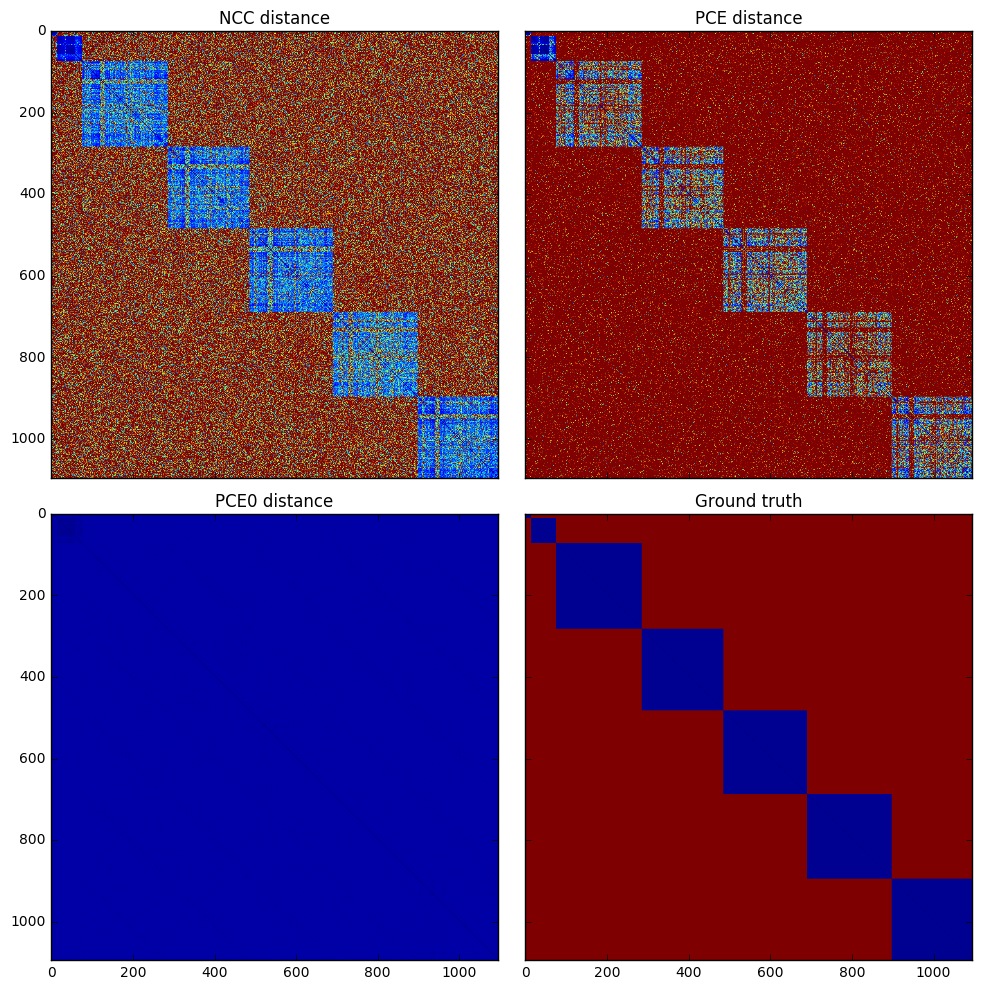

In [36]:
if True:

    dataset = "praktica" #.argv[1]
    directory = directory + "/" + dataset

    #load the distance matrixes from files
    matrix_pce = numpy.fromfile(directory + "/matrix-" + dataset + "-pce.dat", dtype='>d')
    print("max=")
    print(matrix_pce.max())
    print("min=")
    print(matrix_pce.min())
    matrix_pce0 = numpy.fromfile(directory + "/matrix-" + dataset + "-pce0.dat", dtype='>d')
    matrix_ncc = numpy.fromfile(directory + "/matrix-" + dataset + "-ncc.dat", dtype='>d')

    matrix_pce, matrix_ncc = map_ncc_scores_to_pce_domain(matrix_pce, matrix_ncc)
    matrix_ncc = convert_similarity_to_distance2(matrix_ncc)
   
    matrix_pce = convert_similarity_to_distance(matrix_pce)# for now only for PCE the new conversion is used
    # pyplot.hist(matrix_pce, bins =100) # here we draw the histogram of the new distances. Disabled by default because it takes time
    print("max=")
    print(matrix_pce.max())
    print("min=")
    print(matrix_pce.min())
    matrix_pce0 = convert_similarity_to_distance2(matrix_pce0)

    matrix_ans = get_ground_truth()    
    
    plot_distance_matrices(matrix_ncc, matrix_pce, matrix_pce0, matrix_ans)

In [38]:
size = math.sqrt(len(matrix_pce))
print(size)
A = matrix_pce.reshape(size,size)

33.090784215548595


C:\Users\sonja\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


ValueError: total size of new array must be unchanged

In [14]:
print(A)

[[  0.00000000e+00   2.84021404e-01   4.61572736e-01 ...,   6.09679775e+01
    1.24763474e+03   1.89212460e+02]
 [  2.84021404e-01   0.00000000e+00   4.19755803e-01 ...,   1.15830659e+02
    3.15332185e+02   2.95110187e+01]
 [  4.61572736e-01   4.19755803e-01   0.00000000e+00 ...,   2.93973053e+01
    2.96096684e+02   5.19118626e+01]
 ..., 
 [  6.09679775e+01   1.15830659e+02   2.93973053e+01 ...,   0.00000000e+00
    3.63545417e+01   1.44391290e+03]
 [  1.24763474e+03   3.15332185e+02   2.96096684e+02 ...,   3.63545417e+01
    0.00000000e+00   9.07443305e-02]
 [  1.89212460e+02   2.95110187e+01   5.19118626e+01 ...,   1.44391290e+03
    9.07443305e-02   0.00000000e+00]]


In [5]:
from sklearn import manifold
model = manifold.TSNE(metric="precomputed", n_components = 3, n_iter=100000)
Y = model.fit_transform(A) 

In [6]:
print(Y)
textFile = open('tsne_coord_pentax.txt', 'w')
names = open (directory + '/filelist.txt', 'r')
for item in Y:
    name = names.readline()
    name = name.split("\n")[0]
    #print item # This prints fine    
    textFile.write(name)
    for number in item:        
        textFile.write(" " + str(number) )
    textFile.write('\n')
textFile.close()
names.close()

        

[[-10.12221907 -13.04949711   1.20041286]
 [ -3.45564459  -7.65304393   9.88473138]
 [ -2.07488087 -23.57828952   2.88018885]
 ..., 
 [ 14.93383538  -0.25186123 -14.22731186]
 [  3.15242466   2.5835646   -3.72832107]
 [  3.06831145   5.13818823  -4.31319032]]


In [24]:
from sklearn import cluster
dbscan = cluster.DBSCAN(eps=2.5, metric='precomputed')

dbscan.fit(A)
labels = dbscan.labels_
print(labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0 -1 -1 -1 -1  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0 -1  0  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1
 -1  1  2  2

In [8]:
407044-406406

638

In [9]:
638*637

406406

In [10]:
math.sqrt(407044)

638.0